In [1]:
from __future__ import division
import os
import numpy as np
import time
import matplotlib.pyplot as plt
import scipy as scp
import pylab as pyl

import warnings
warnings.filterwarnings('ignore')
np.random.seed(1234)

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
if not os.path.isdir('DampedNewtonTesting_images'):
    os.makedirs('DampedNewtonTesting_images')

In [3]:
"""To compute distance matrix"""
def distmat(x,y):
    
    return np.sum(x**2,0)[:,None] + np.sum(y**2,0)[None,:] - 2*x.transpose().dot(y)

"""To Normalise a vector"""
normalize = lambda a: a/np.sum(a)

"""To Compute P"""
def GetP(u,K,v):
    return u*K*(v.T)

def plotp(x, col,plt, scale=200, edgecolors="k"):
  return plt.scatter(x[0,:], x[1,:], s=scale, edgecolors=edgecolors,  c=col, cmap='plasma', linewidths=2)

In [4]:
N=[400,500]

In [7]:
import computational_OT

In [8]:
x=np.random.rand(2,N[0])-0.5
theta =2*np.pi*np.random.rand(1,N[1])
r=0.8+.2*np.random.rand(1,N[1])
y=np.vstack((r*np.cos(theta),r*np.sin(theta)))

In [9]:
rho=0.95
c=0.05
DampedNewtonP=[]
results_DampedNewton  = []
times_DampedNewton    = []
Hessians_DampedNewton = []

#epsilons=[0.05,0.08,0.1]
#epsilons=[0.1, 0.2, 0.3, 0.4, 0.5, 0.75, 1.0 ]
epsilons = [ 1.0, 0.5, 0.1, 0.05 ]
for eps in epsilons:
    # Line Search
    print("Damped Newton for epsilon="+str(eps)+":")    
    #Cost matrix
    C = distmat(x,y)

    # a and b
    a = normalize(np.ones(N[0]))
    a=a.reshape(a.shape[0],-1)
    b = normalize(np.ones(N[1]))
    b=b.reshape(b.shape[0],-1)

    #Epsilon 

    # epsilon = .05

    #Kernel
    K=np.exp(-C/eps)

    f,g=0*a,0*b

    print("Doing for (",N[0],N[1],").")
    print( " |- Iterating")  
    start=time.time()
    Optimizer=computational_OT.DampedNewton(K,a,b,f,g,eps,rho,c)
    out=Optimizer._update(maxiter=50, debug=True)
    results_DampedNewton.append(out)
    end=time.time()
    times_DampedNewton.append(end-start)
    print( " |- Computing P")
    
    DampedNewtonP.append(GetP(np.exp(out[0]/eps),K,np.exp(out[1]/eps)))
    print( " |- Recording (unstabilized) Hessian \n")

    mat  = -eps*Optimizer.Hessian
    diag = 1/np.sqrt( np.vstack( (a,b) ) ).flatten()
    mat = diag*mat*diag
    Hessians_DampedNewton.append( mat )


Damped Newton for epsilon=1.0:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.5:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  16
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.1:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  14
 |- Computing P
 |- Recording (unstabilized) Hessian 

Damped Newton for epsilon=0.05:
Doing for ( 400 500 ).
 |- Iterating
Terminating after iteration:  15
 |- Computing P
 |- Recording (unstabilized) Hessian 



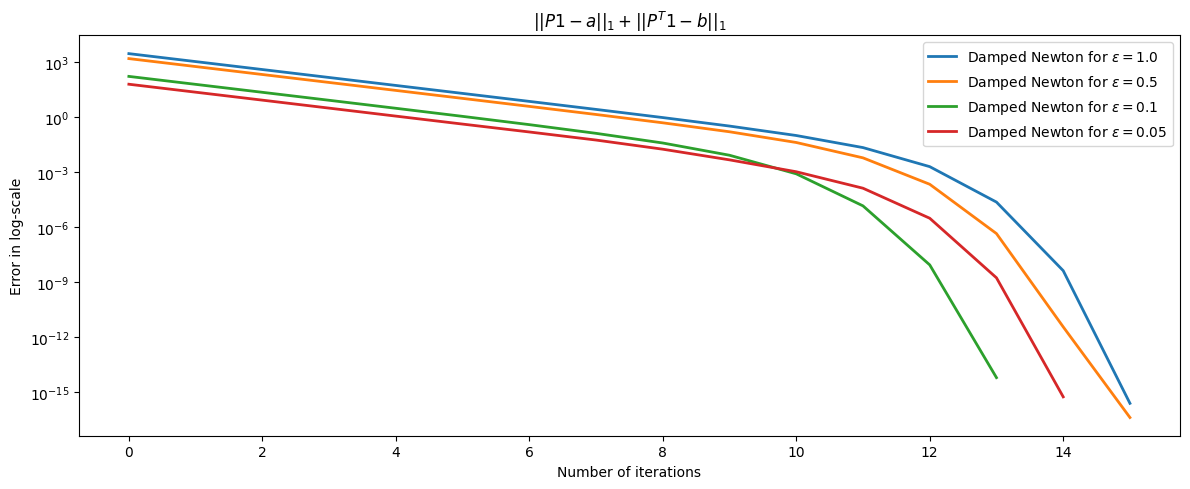


 Error plots can increase! The error is not the objective function!


In [10]:
plt.figure(figsize = (12,5))
plt.title("$$")
plt.title("$||P1 -a||_1+||P^T 1 -b||_1$")

for i in range(len(results_DampedNewton)):
  error=np.asarray(results_DampedNewton[i][2])+np.asarray(results_DampedNewton[i][3])
  plt.plot( error,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Error in log-scale")
plt.legend()
plt.yscale( 'log')
plt.tight_layout()
plt.savefig("DampedNewtonTesting_images/ErrorLinesearchNewton.png")
plt.show()

print("\n Error plots can increase! The error is not the objective function!")

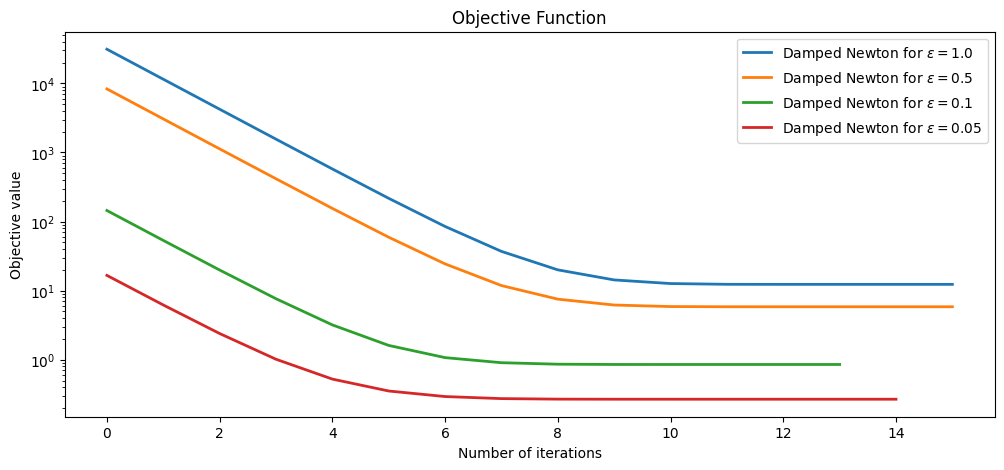

In [11]:
plt.figure(figsize = (12,5))
plt.title("$$")

plt.title("Objective Function")

for i in range(len(results_DampedNewton)):
  value = np.asarray(results_DampedNewton[i][4])
  value = -(value)
  plt.plot( value,label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Objective value")
plt.yscale('log')
plt.legend()
plt.savefig("DampedNewtonTesting_images/ObjectiveLineSearchNewton.png")
plt.show()


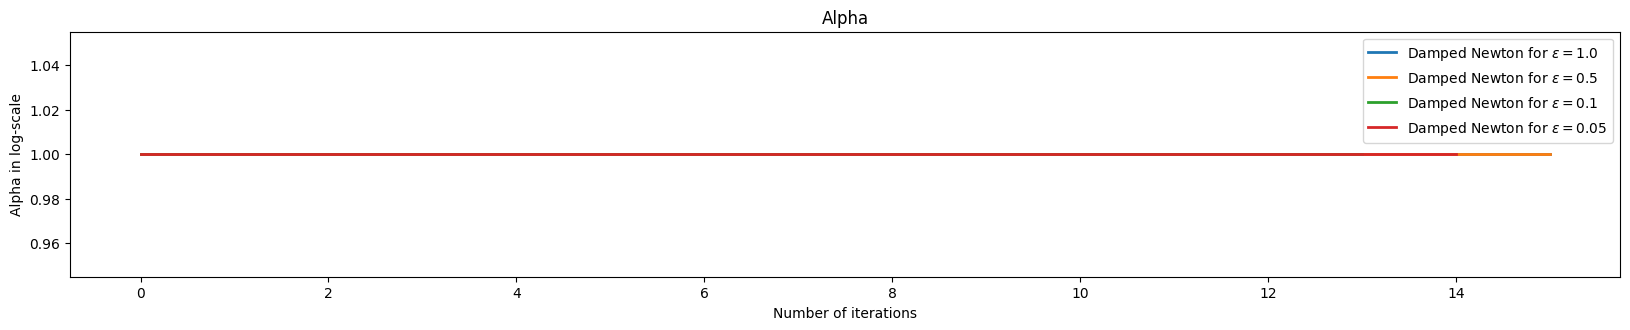

In [12]:
plt.figure(figsize = (20,7))
plt.subplot(2,1,1),
plt.title("Alpha")

for i in range(len(results_DampedNewton)):
  plt.plot( np.asarray(results_DampedNewton[i][5]),label='Damped Newton for $\epsilon=$'+ str(epsilons[i]), linewidth = 2)

plt.xlabel("Number of iterations")
plt.ylabel("Alpha in log-scale")
plt.legend()
# plt.yscale( 'log')
plt.savefig("DampedNewtonTesting_images/AlphaLineSearchNewton.png")
plt.show()



In [13]:
def print_spectral_statistics(mat, stabilize=False):
    if stabilize:
        # Stabilizing largest and smallest eigenvalue
        min_vector = np.hstack( (np.ones(N[0]), -np.ones(N[1])) )
        max_vector = np.hstack( (np.ones(N[0]),  np.ones(N[1])) )
        norm = np.sqrt( N[0] + N[1] )
        min_vector = min_vector/norm
        max_vector = max_vector/norm
        min_vector = min_vector.reshape( (min_vector.shape[0], 1) )
        max_vector = max_vector.reshape( (max_vector.shape[0], 1) )
        #
        mat = mat + np.dot( min_vector, min_vector.T)
        mat = mat - np.dot( max_vector, max_vector.T)
    # endif
    eig, v = np.linalg.eigh( mat )
    sorting_indices = np.argsort(eig)
    eig = eig[sorting_indices]
    v   = v[:, sorting_indices]
    
    #print( "Mean eigenvalue: ", np.mean(eig) )
    print( "List of smallest eigenvalues: ", eig[:10])
    print( "List of largest  eigenvalues: ", eig[-10:])
    min_index = np.argmin(eig)
    max_index = np.argmax(eig)
    min_value = eig[ min_index ]
    max_value = eig[max_index]
    min_vector = v[:, min_index]
    min_vector = min_vector/min_vector[0]
    max_vector = v[:,max_index]
    max_vector = max_vector/max_vector[0]
    condition_number = max_value/min_value
    # Test smallest and largest
    # print( "Min eigenvalue vector: ", min_vector)
    # print( "Max eigenvalue vector: ", max_vector)
    #
    #print( v[:,0]*np.sqrt( self.N1 + self.N2))
    #vector = v[:,0]
    #test = np.dot( result, vector)
    #print( np.linalg.norm(test) )
    #print("Min absolute eigenvalues: ", min_value)
    #print("Norm of v-1: ", np.linalg.norm(min_vector-eig_vector))
    print("Condition number: ", condition_number)
    # plt.hist( eig, 50)
    # plt.title( "Histogram of eigenvalues for Hessian")
    # plt.xlabel( "Eigenvalues")
    # plt.yscale( "log" )
    # plt.show()
    return eig,v

In [14]:
eigs=[]
eigvecs=[]
for i in range(len(epsilons)):
    eps = epsilons[i]
    print("Spectral statistics of Hessian for epsilon="+str(eps))
    Hessian = Hessians_DampedNewton[i]
    ev=print_spectral_statistics( Hessian, stabilize=False)
    eigs.append(ev[0])
    eigvecs.append(ev[1])
    print("")


Spectral statistics of Hessian for epsilon=1.0
List of smallest eigenvalues:  [0.10557281 0.67416524 0.70337728 0.91966842 0.95134932 0.99034495
 0.99083823 0.9918135  0.99875306 0.99880284]
List of largest  eigenvalues:  [1.00119723 1.00124702 1.00818659 1.00916183 1.00965511 1.04865074
 1.08033164 1.29662278 1.32583483 1.89442726]
Condition number:  17.94427190999921

Spectral statistics of Hessian for epsilon=0.5
List of smallest eigenvalues:  [0.10557281 0.46997333 0.50339366 0.77051103 0.85001159 0.94712411
 0.94974272 0.97441123 0.98906493 0.98975838]
List of largest  eigenvalues:  [1.01024162 1.01093507 1.02558877 1.05025728 1.05287589 1.14998841
 1.22948897 1.49660634 1.53002667 1.89442719]
Condition number:  17.944271909999205

Spectral statistics of Hessian for epsilon=0.1
List of smallest eigenvalues:  [0.10557281 0.18223332 0.19057081 0.32107781 0.40824151 0.55190017
 0.56183459 0.70892143 0.71575953 0.81508654]
List of largest  eigenvalues:  [1.18491351 1.28424051 1.291078

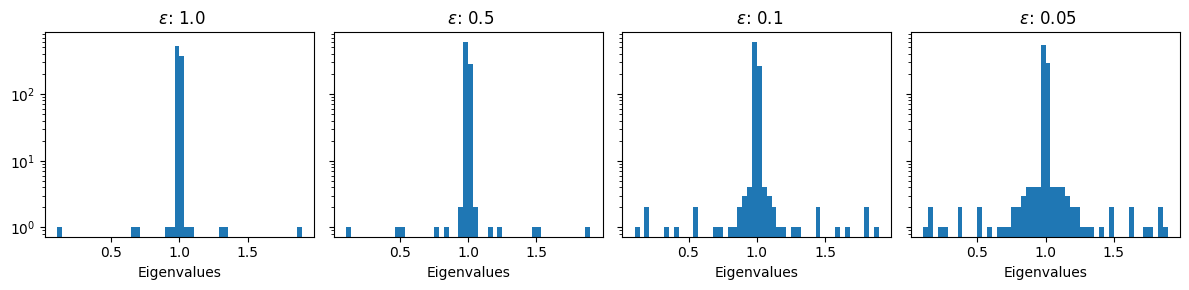

In [15]:
fig,ax=plt.subplots(figsize=(12,3),nrows=1, ncols=len(epsilons), sharey=True)
plt.title("Histogram of eigenvalues.")
for i in range(len(epsilons)):
    ax[i].hist( eigs[i], 50)
    ax[i].set_title( " $\epsilon$: "+str(epsilons[i]))
    ax[i].set_xlabel("Eigenvalues")
    ax[i].set_yscale( "log" )
plt.subplots_adjust(wspace=0,hspace=0)
plt.tight_layout()
plt.savefig("DampedNewtonTesting_images/eigenhistunstabilized.png")
plt.show()

## Heatmaps

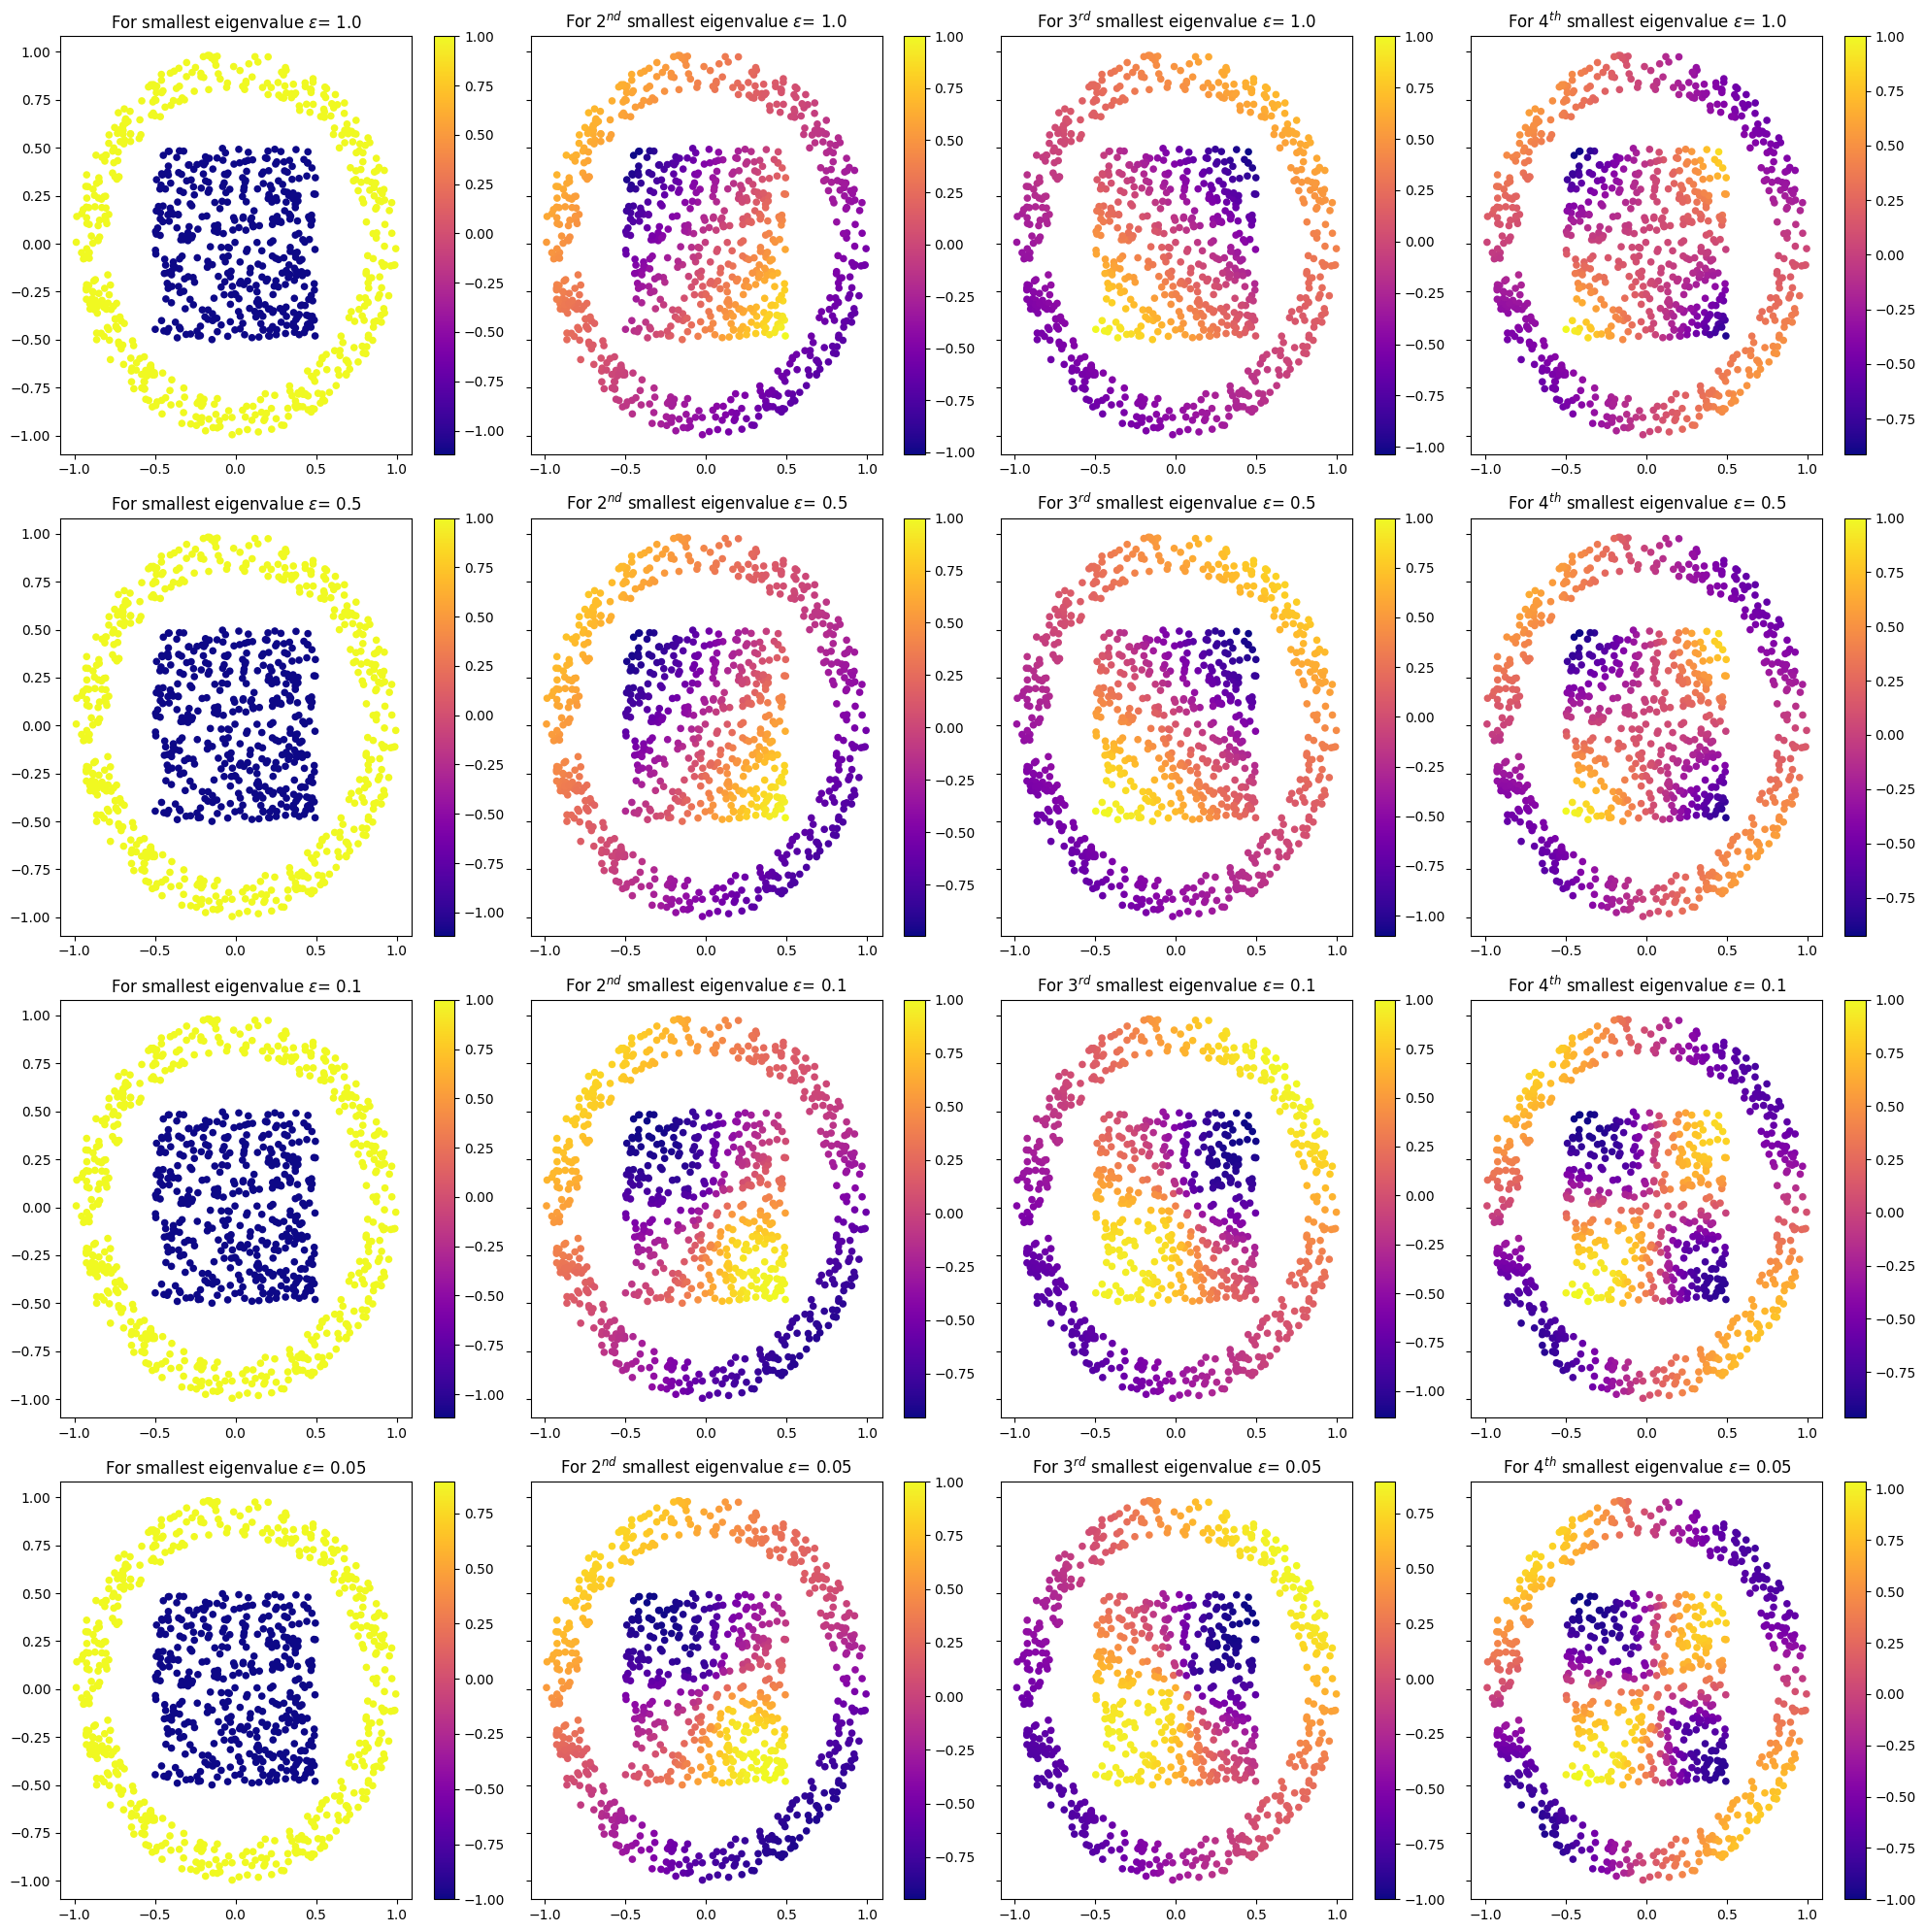

In [16]:
eigenmodes_count = 4

X=np.hstack((np.hstack((x[0,:],y[0,:]))[:,None],np.hstack((x[1,:],y[1,:]))[:,None]))
fig, ax = plt.subplots(figsize=(20,20),nrows=len(epsilons), ncols=eigenmodes_count,sharey=True)
scale = 30

courant_modes = []

for i in range(len(epsilons)):
    eigenvectors = eigvecs[i]
    courant_modes.append( [] )
    for j in range(eigenmodes_count):
        function_as_vector = eigenvectors[:,j]
        function_as_vector = function_as_vector/np.max(function_as_vector)
        # Flip sign if anti-correlated
        if i>0:
            old_mode = courant_modes[i-1][j]
            correlation = np.dot( old_mode, function_as_vector)/(np.linalg.norm(old_mode)*np.linalg.norm(function_as_vector))
            if correlation<-0.1:
                function_as_vector = -function_as_vector
            #print( "epsilon: ", i, " -- corr = ", correlation )
        # Record
        courant_modes[i].append( function_as_vector )
        # Plot
        im1 = ax[i][j].scatter(X.T[0,:], X.T[1,:], s=scale, edgecolors=(0,0,0,0),  c=function_as_vector, cmap='plasma', linewidths=2)
        fig.colorbar(im1,ax=ax[i][j])
    # end for
    ax[i][0].set_title("For smallest eigenvalue $\epsilon$= "+str(epsilons[i]))
    ax[i][1].set_title("For $2^{nd}$ smallest eigenvalue $\epsilon$= "+str(epsilons[i]))
    ax[i][2].set_title("For $3^{rd}$ smallest eigenvalue $\epsilon$= "+str(epsilons[i]))
    ax[i][3].set_title("For $4^{th}$ smallest eigenvalue $\epsilon$= "+str(epsilons[i]))
    #ax[i][4].set_title("For $5^{th}$ smallest eigenvalue $\epsilon$= "+str(epsilons[i]))
# end for

#fig.colorbar(im1, ax=ax.ravel().tolist())
plt.xlim(np.min(X.T[0,:])-.1,np.max(X.T[0,:])+.1)
plt.ylim(np.min(X.T[1,:])-.1,np.max(X.T[1,:])+.1)
plt.subplots_adjust(wspace=0,hspace=0.09)
plt.tight_layout()
plt.savefig("DampedNewtonTesting_images/Eigenheatmaplowest.png")
plt.show();



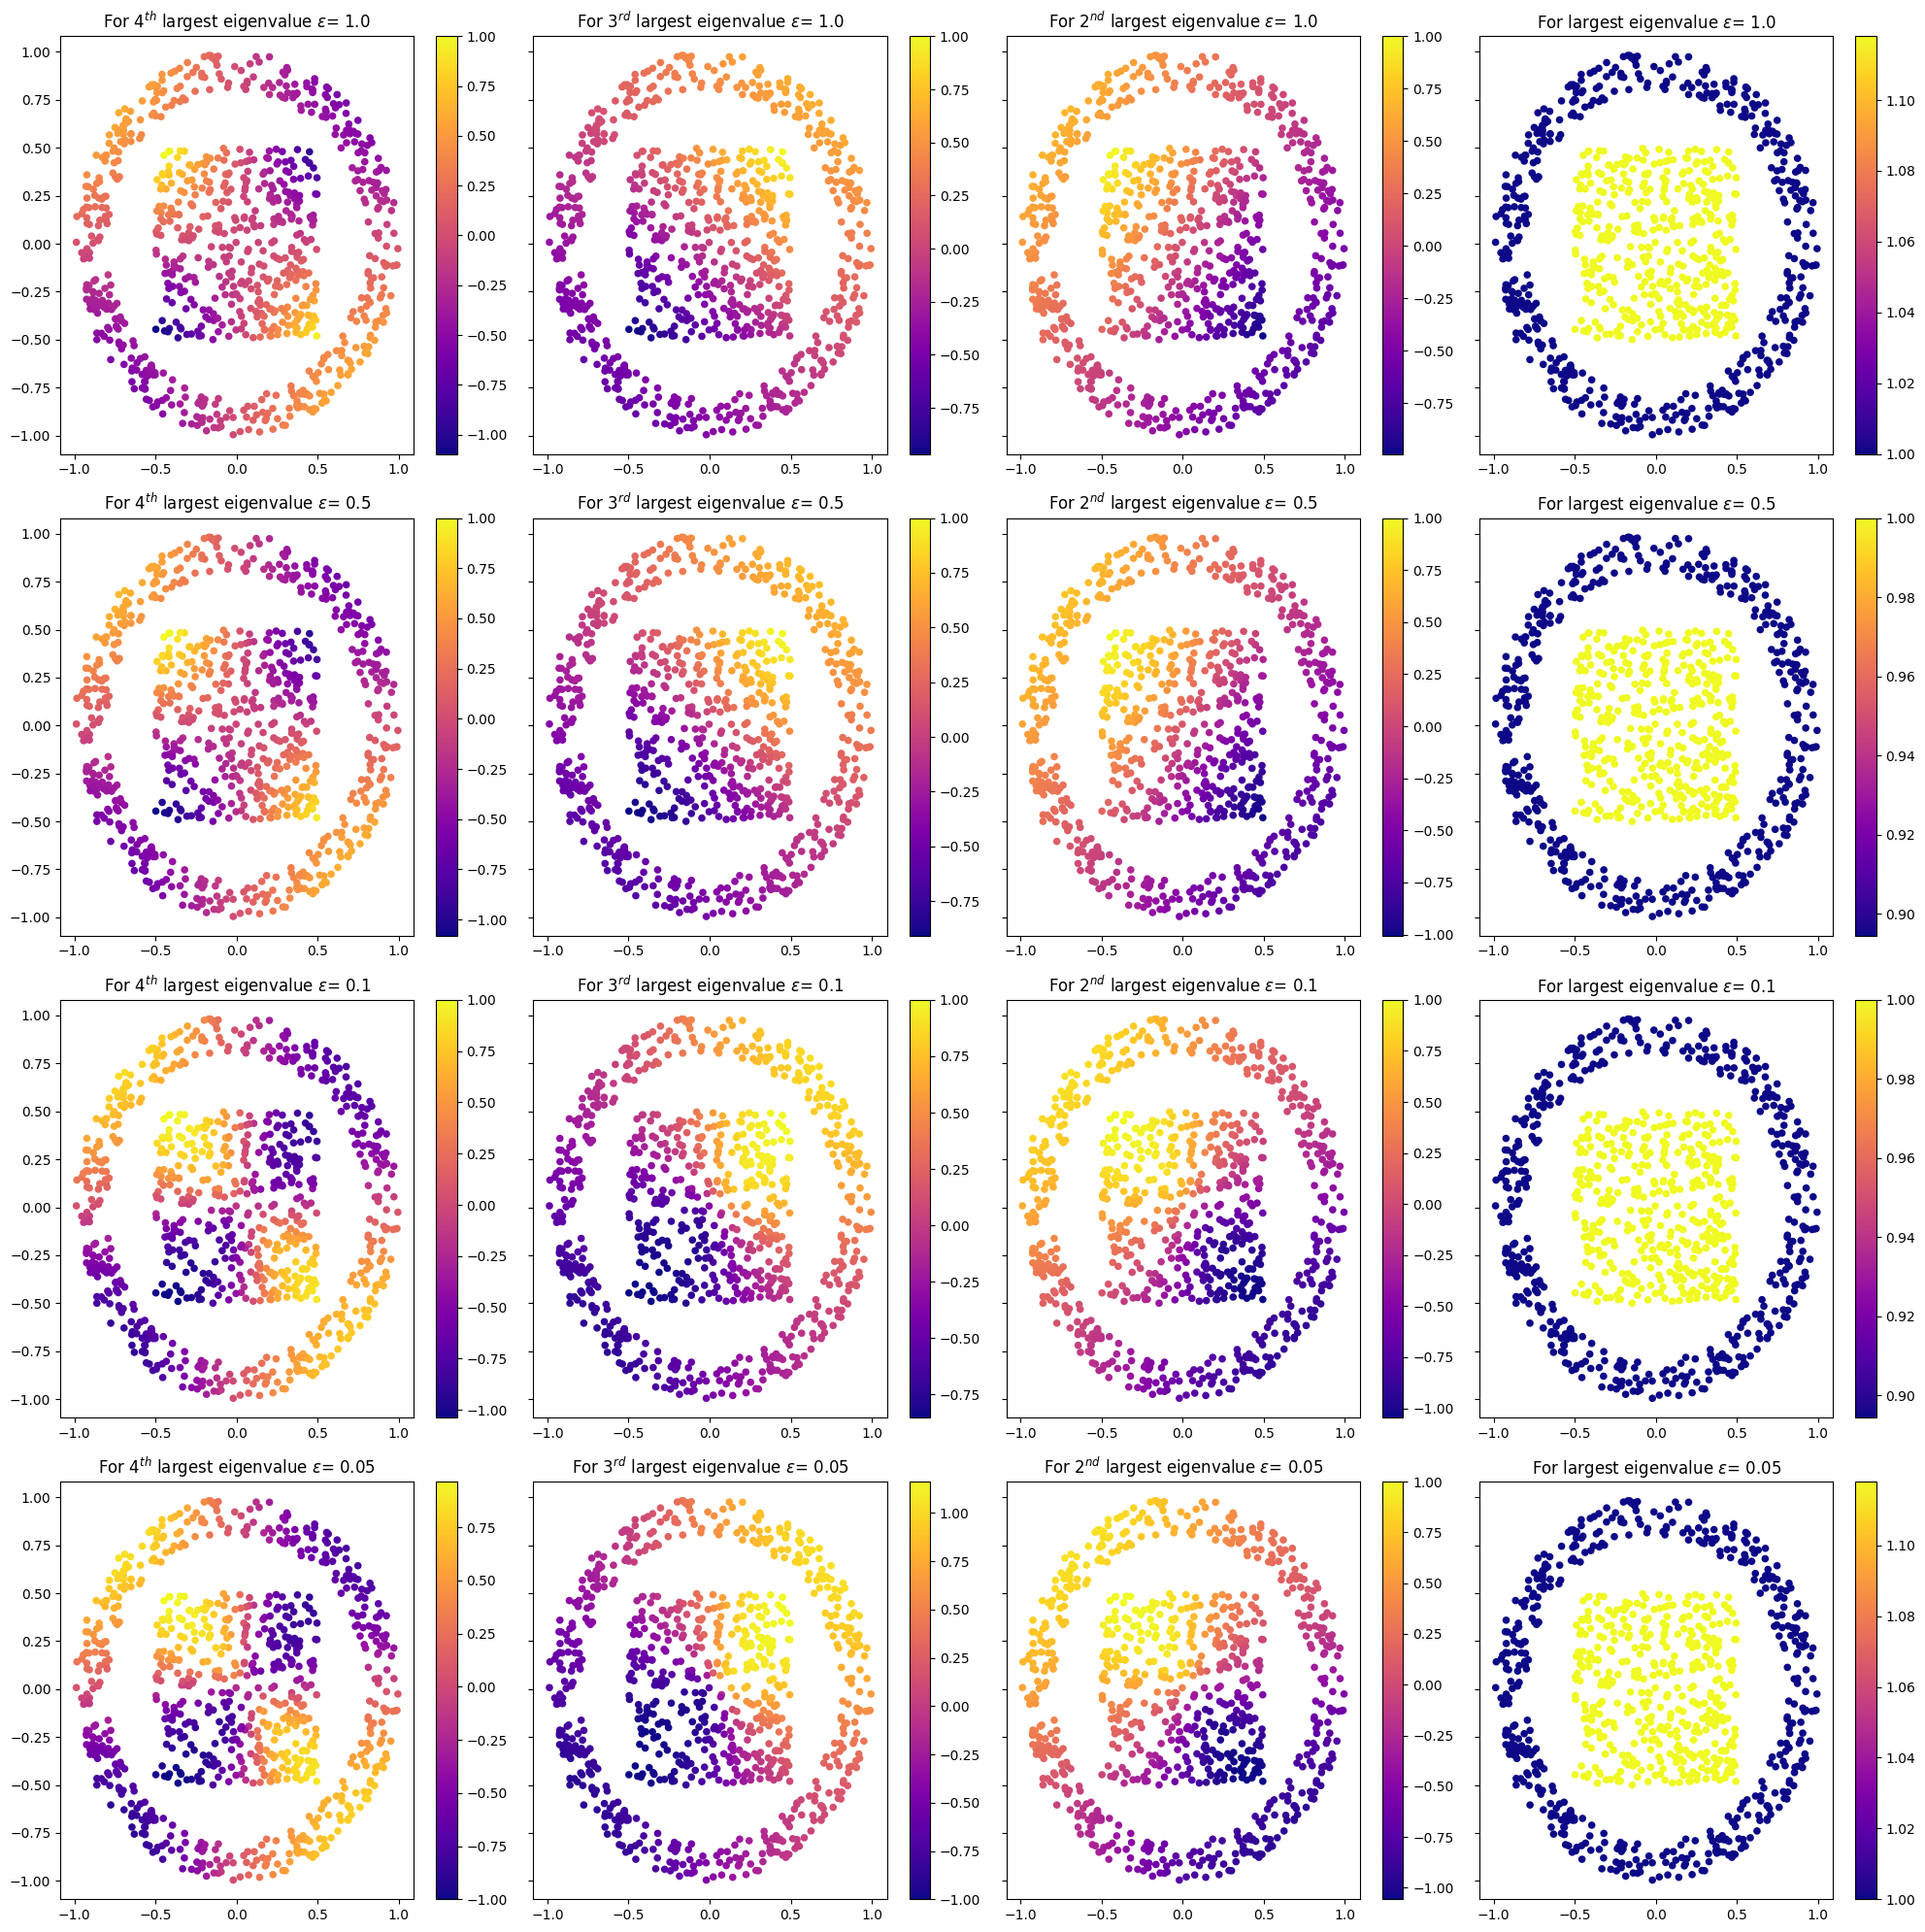

In [17]:
eigenmodes_count=4
X=np.hstack((np.hstack((x[0,:],y[0,:]))[:,None],np.hstack((x[1,:],y[1,:]))[:,None]))
fig, ax = plt.subplots(figsize=(20,20),nrows=len(epsilons), ncols=eigenmodes_count,sharey=True)
scale = 30
courant_modes = []

for i in range(len(epsilons)):
    eigenvectors = eigvecs[i]
    courant_modes.append( [] )
    for j in range(eigenmodes_count):
        function_as_vector = eigenvectors[:,N[0]+N[1]-j-1]
        function_as_vector = function_as_vector/np.max(function_as_vector)
        # Flip sign if anti-correlated
        if i>0:
            old_mode = courant_modes[i-1][j]
            correlation = np.dot( old_mode, function_as_vector)/(np.linalg.norm(old_mode)*np.linalg.norm(function_as_vector))
            if correlation<-0.1:
                function_as_vector = -function_as_vector
            #print( "epsilon: ", i, " -- corr = ", correlation )
        # Record
        courant_modes[i].append( function_as_vector )
        # Plot
        im = ax[i][eigenmodes_count-j-1].scatter(X.T[0,:], X.T[1,:], s=scale, edgecolors=(0,0,0,0),  c=function_as_vector, cmap='plasma', linewidths=2)
        fig.colorbar(im,ax=ax[i][eigenmodes_count-j-1])
    # end for
    ax[i][3].set_title("For largest eigenvalue $\epsilon$= "+str(epsilons[i]))
    ax[i][2].set_title("For $2^{nd}$ largest eigenvalue $\epsilon$= "+str(epsilons[i]))
    ax[i][1].set_title("For $3^{rd}$ largest eigenvalue $\epsilon$= "+str(epsilons[i]))
    ax[i][0].set_title("For $4^{th}$ largest eigenvalue $\epsilon$= "+str(epsilons[i]))
    #ax[i][0].set_title("For $5^{th}$ largest eigenvalue $\epsilon$= "+str(epsilons[i]))

# plt.axis("off")
plt.xlim(np.min(X.T[0,:])-.1,np.max(X.T[0,:])+.1)   
plt.ylim(np.min(X.T[1,:])-.1,np.max(X.T[1,:])+.1)
plt.subplots_adjust(wspace=0,hspace=0.09)
plt.tight_layout()
plt.savefig("DampedNewtonTesting_images/Eigenheatmaplargest.png")
plt.show();

